# Homework 1

In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!unzip -qq dul_2021/Homework/hw1/data/hw1_data.zip -d dul_2021/Homework/hw1/data/
!mv -v dul_2021/Homework/hw1/data/hw1_data/* dul_2021/Homework/hw1/data/
!rmdir dul_2021/Homework/hw1/data/hw1_data/
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 123, done.
remote: Counting objects: 100% (123/123), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 123 (delta 48), reused 71 (delta 22), pack-reused 0
Receiving objects: 100% (123/123), 26.19 MiB | 13.47 MiB/s, done.
Resolving deltas: 100% (48/48), done.
renamed 'dul_2021/Homework/hw1/data/hw1_data/geoffrey-hinton.jpg' -> 'dul_2021/Homework/hw1/data/geoffrey-hinton.jpg'
renamed 'dul_2021/Homework/hw1/data/hw1_data/mnist_colored.pkl' -> 'dul_2021/Homework/hw1/data/mnist_colored.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/mnist.pkl' -> 'dul_2021/Homework/hw1/data/mnist.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/shapes_colored.pkl' -> 'dul_2021/Homework/hw1/data/shapes_colored.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/shapes.pkl' -> 'dul_2021/Homework/hw1/data/shapes.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/smiley.jpg' -> 'dul_2021/Homework/hw1/data/smiley.jpg'
Processing ./dul_202

In [2]:
from dul_2021.utils.hw1_utils import *

In [3]:
plt.rcParams["axes.labelsize"] = 25.
plt.rcParams["xtick.labelsize"] = 20.
plt.rcParams["ytick.labelsize"] = 20.
plt.rcParams["legend.fontsize"] = 18.

plt.rcParams["figure.figsize"] = [8., 6.]

# MADE

In this question, you will implement [MADE](https://arxiv.org/abs/1502.03509). In the first part, you will use MADE to model a simple 2D joint distribution, and in the second half, you will train MADE on image datasets.

## Part (a) Fitting 2D Data

First, you will work with bivariate data of the form $x = (x_0,x_1)$, where $x_0, x_1 \in \{0, \dots, d\}$. We can easily visualize a 2D dataset by plotting a 2D histogram. Run the cell below to visualize our datasets.

Dataset 1


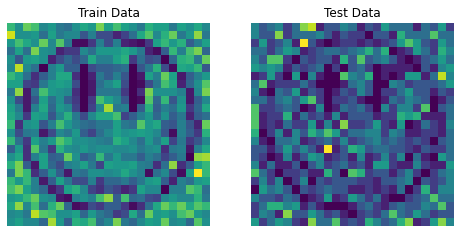

Dataset 2


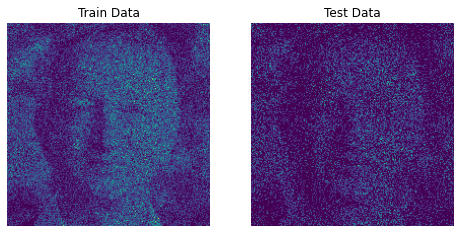

In [4]:
visualize_q1a_data(dset_type=1)
visualize_q1a_data(dset_type=2)
# you can access data with get_data_q1_a(dset_type=1)

Implement and train a MADE model through maximum likelihood to represent $p(x_0, x_1)$ on the given datasets, with any autoregressive ordering of your choosing. 

A few notes:
* You do not need to do training with multiple masks
* You made find it useful to one-hot encode your inputs. 

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Visualize the learned 2D distribution by plotting a 2D heatmap


### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [7]:
class MaskedLinear(nn.Linear):  # хотим поместить маску в линейный блок
    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias)        
        self.register_buffer('mask', torch.ones(out_features, in_features))  # делаем, чтобы маски не входили в параметры
        
    def set_mask(self, mask):
        # copy mask
        self.mask.data.copy_(mask)
        return self
        
    def forward(self, input):
        return F.linear(input, self.mask * self.weight, self.bias)  # маскируем веса

In [8]:
def to_one_hot(x, d):  
  batch_size = x.shape[0]
  x = x.long().contiguous().view(-1)  
  one_hot_vectors = torch.zeros(size=(x.shape[0], d)).to(device)
  one_hot_vectors.scatter_(1, x.unsqueeze(1), 1)
  return one_hot_vectors.view(batch_size, -1)

In [18]:
class MADE(nn.Module):
  def __init__(self, masked_matrix_list, d, input_shape, hidden_size):
    super().__init__()
    self.d = d
    self.input_shape = input_shape
    self.input_size = np.prod(input_shape)
    self.model = nn.Sequential(
        MaskedLinear(self.input_size * d, hidden_size).set_mask(masked_matrix_list[0]),
        nn.ReLU(),
        MaskedLinear(hidden_size, hidden_size).set_mask(masked_matrix_list[1]),
        nn.ReLU(),
        MaskedLinear(hidden_size, self.input_size*d).set_mask(masked_matrix_list[2])
    )

  def forward(self, x):
    one_hot_vectors = to_one_hot(x, self.d)
    outs = self.model(one_hot_vectors)
    batch_size = one_hot_vectors.shape[0]
    outs = outs.view(batch_size, self.input_size, self.d)
    return outs.permute(0, 2, 1).contiguous().view((batch_size, self.d, *self.input_shape))

  def loss(self, x):
    return F.cross_entropy(self.forward(x), x.long())

  def distribution(self):
    with torch.no_grad():
      x = np.mgrid[0:self.d, 0:self.d].reshape(2, self.d ** 2).T
      x = torch.tensor(x).to(device).long()
      log_probs = F.log_softmax(self.forward(x), dim=1)
      distribution = torch.gather(log_probs, 1, x.unsqueeze(1)).squeeze(1).sum(dim=1)
      distribution = distribution.exp().reshape(self.d, self.d).cpu().numpy()
    return distribution

  def sample(self, n):
    with torch.no_grad():
      samples = torch.zeros(n, self.input_size).to(device)
      array = np.arange(self.input_size)
      for i in range(self.input_size):
        logits = self.forward(samples).reshape(n, self.d, self.input_size)[:, :,  array[i]]
        probs = F.softmax(logits, dim=1)
        samples[:, array[i]] = torch.multinomial(probs, 1).squeeze(-1)
      samples = samples.reshape(n, *self.input_shape)
    return samples.cpu().numpy().transpose(0, 2, 3, 1)

In [10]:
def make_mask(input_shape, d, hidden_size):
  input_size = np.prod(input_shape)
  m0 = np.repeat(np.arange(input_size), d)
  m1 = np.random.randint(low=m0.min(), high=input_size-1, size=hidden_size)
  m2 = np.random.randint(low=m1.min(), high=input_size-1, size=hidden_size)
  m3 = np.repeat(np.arange(input_size), d)

  M1 = torch.from_numpy((m1[:, None] >= m0[None, :]).astype(np.uint8))
  M2 = torch.from_numpy((m2[:, None] >= m1[None, :]).astype(np.uint8))
  M3 = torch.from_numpy((m3[:, None] > m2[None, :]).astype(np.uint8))
  return [M1, M2, M3]

In [11]:
def train(model, train_loader, test_loader, optimizer, epochs):
  train_losses, test_losses = [], []
  for epoch in range(epochs):
    model.train()    
    epoch_losses = []
    for x in train_loader:
      x = x.to(device)
      loss = model.loss(x)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      epoch_losses.append(loss.item())
    train_losses.extend(epoch_losses)

    test_loss = eval_loss(model, test_loader)
    test_losses.append(test_loss)
    if epoch % 10 == 0:
      print(f'Epoch {epoch}, Test loss {test_loss}')
  return train_losses, test_losses

def eval_loss(model, data_loader):
  model.eval()
  total_loss = 0
  with torch.no_grad():
    for x in data_loader:
      x = x.to(device)
      loss = model.loss(x)
      total_loss += loss.item() * x.shape[0]
  return total_loss / len(data_loader.dataset)

In [12]:
def q1_a(train_data, test_data, d, dset_id):
  """
  train_data: An (n_train, 2) numpy array of integers in {0, ..., d-1}
  test_data: An (n_test, 2) numpy array of integers in {0, .., d-1}
  d: The number of possible discrete values for each random variable x1 and x2
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (d, d) of probabilities (the learned joint distribution)
  """
  
  """ YOUR CODE HERE """
  epoch = 20
  if dset_id == 1:
    lr = 3e-3
  else:
    lr = 8e-4

  hidden_size = 128
  masked_matrices = make_mask((2,), d, hidden_size)
  
  model = MADE(masked_matrices, d, (2,), hidden_size).to(device)
  model.train()
  optimizer = optim.Adam(model.parameters(), lr=lr)
  
  train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
  test_loader = data.DataLoader(test_data, batch_size=128)
  train_losses, test_losses = train(model, train_loader, test_loader, optimizer, epoch)
  distribution = model.distribution()
  return train_losses, test_losses, distribution

### Results

Once you've implemented `q2_a`, execute the cells below to visualize and save your results



Epoch 0, Test loss 3.1986217212677004
Epoch 10, Test loss 3.18147811126709
Final Test Loss: 3.1783


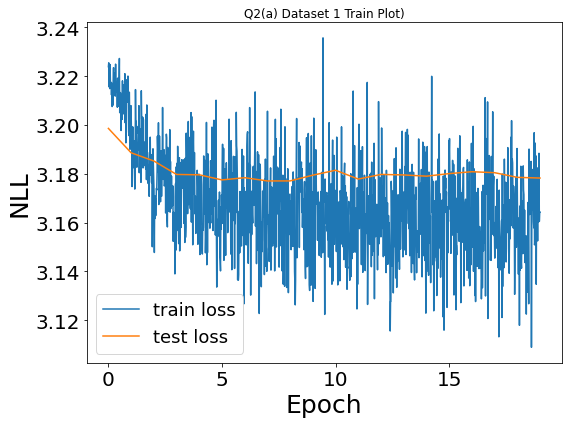

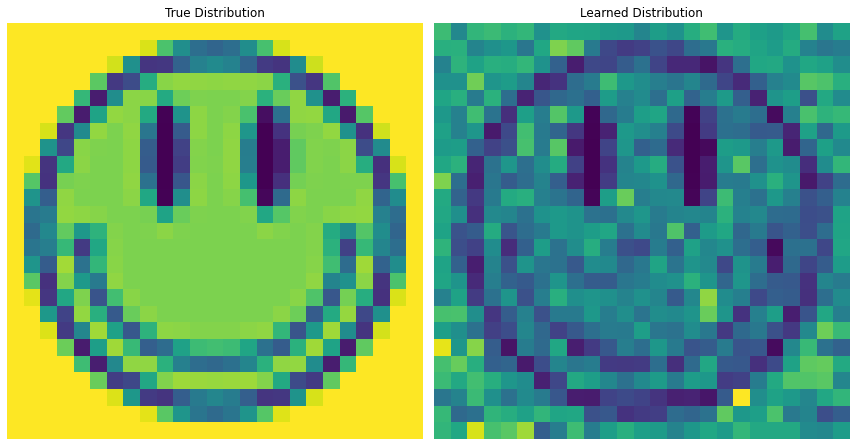

In [13]:
q1_save_results(1, 'a', q1_a)

Epoch 0, Test loss 5.277543148803711
Epoch 10, Test loss 5.287555200958252
Final Test Loss: 5.3045


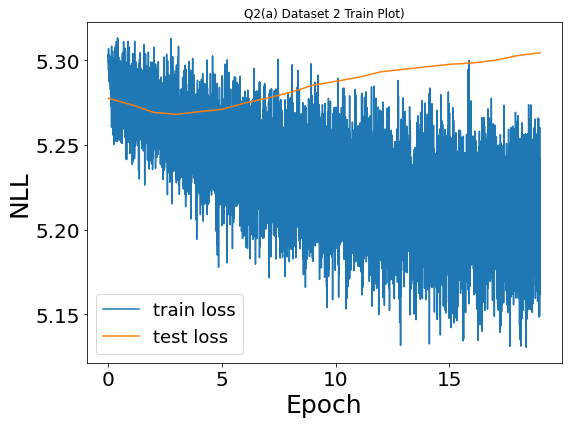

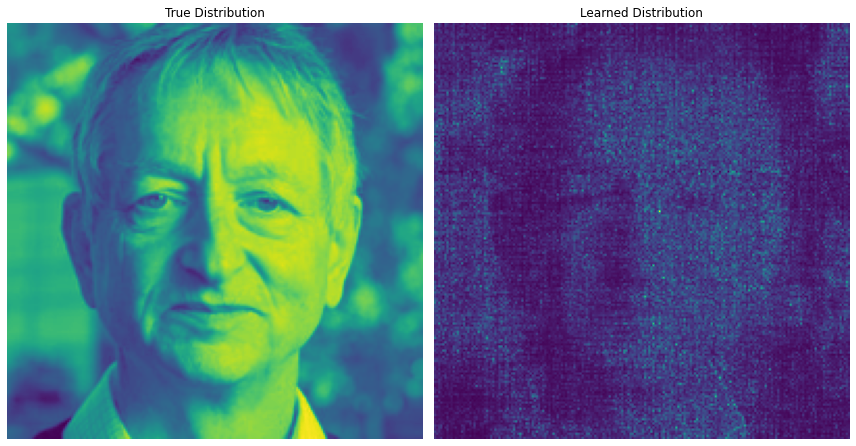

In [14]:
q1_save_results(2, 'a', q1_a)

## Part (b) Shapes and MNIST
Now, we will work with a higher dimensional datasets, namely a shape dataset and MNIST. Run the cell below to visualize the two datasets

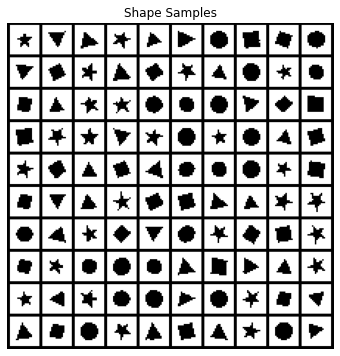

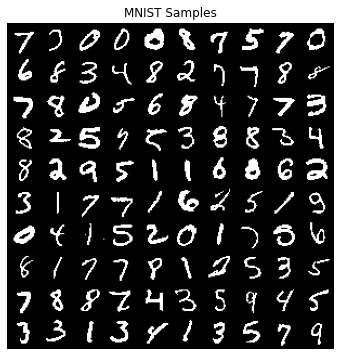

In [15]:
visualize_q1b_data(1)
visualize_q1b_data(2)
# you can access data with get_data_q1_b(dset_type=1)

Implement and train a MADE model on the given binary image datasets. Given some binary image of height $H$ and width $W$, we can represent image $x\in \{0, 1\}^{H\times W}$ as a flattened binary vector $x\in \{0, 1\}^{HW}$ to input into MADE to model $p_\theta(x) = \prod_{i=1}^{HW} p_\theta(x_i|x_{<i})$. Your model should output logits, after which you could apply a sigmoid over 1 logit, or a softmax over two logits (either is fine).

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [16]:
def q1_b(train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    test_data: An (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    image_shape: (H, W), height and width of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
            used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
    """

    train_data = train_data.transpose(0, 3, 1, 2)
    test_data = test_data.transpose(0, 3, 1, 2)
    d = 2
    lr, epoch = 1e-3, 50
    if dset_id == 1:
      hidden_size = 2048
    else:
      hidden_size = 300

    H, W = image_shape
  
    masked_matrices = make_mask((1, H, W), d, hidden_size)
    model = MADE(masked_matrices, d, (1, H, W), hidden_size).to(device)
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=2048)
    train_losses, test_losses = train(model, train_loader, test_loader,  optimizer, epoch)
    
    samples = model.sample(100)
    return train_losses, test_losses, samples    

### Results

Once you've implemented `q2_b`, execute the cells below to visualize and save your results



Epoch 0, Test loss 0.1335802542004652
Epoch 10, Test loss 0.0493327041578184
Epoch 20, Test loss 0.04244849812202081
Epoch 30, Test loss 0.03890598976606782
Epoch 40, Test loss 0.03708273997981175
Final Test Loss: 0.0358


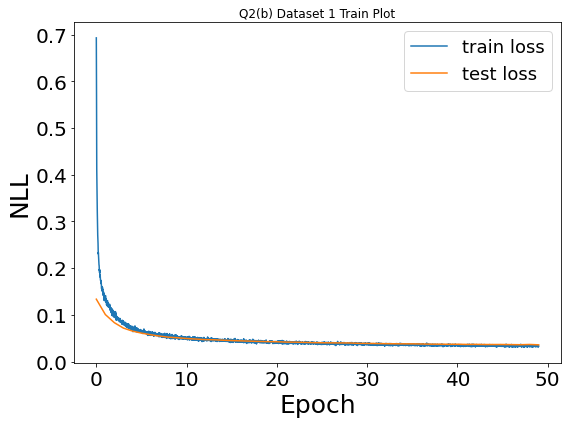

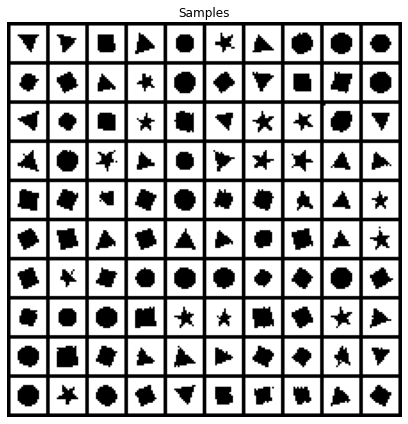

In [19]:
q1_save_results(1, 'b', q1_b)

Epoch 0, Test loss 0.2129679577112198
Epoch 10, Test loss 0.14213305191993714
Epoch 20, Test loss 0.13726942791938782
Epoch 30, Test loss 0.13562539641857146
Epoch 40, Test loss 0.13485576956272124
Final Test Loss: 0.1345


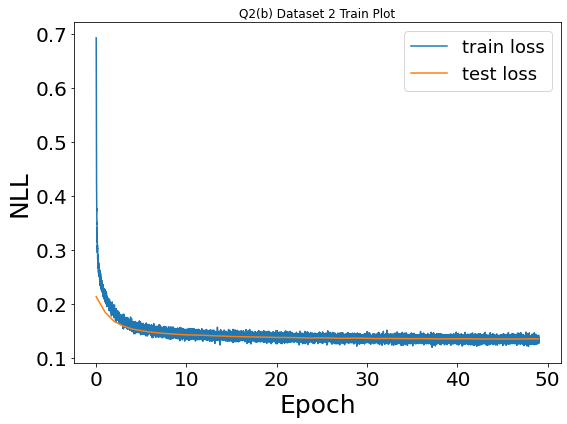

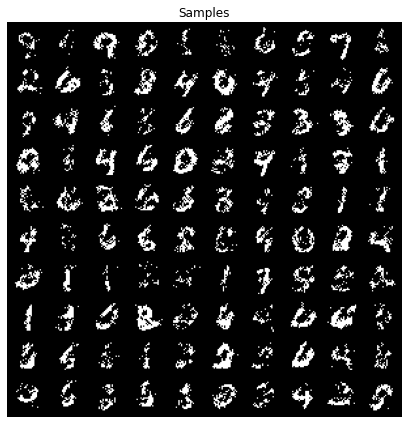

In [20]:
q1_save_results(2, 'b', q1_b)